In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


# Import Libaries 

In [12]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM
from keras.layers import Embedding, Attention, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Load and prepare data
fake_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
real_df = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

fake_df['label'] = 0
real_df['label'] = 1

combined_df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42)

In [4]:
print(combined_df.head())
print("Dataset shape:", combined_df.shape)

                                                   title  \
22216  Ben Stein Calls Out 9th Circuit Court: Committ...   
4436   Trump drops Steve Bannon from National Securit...   
1526   Puerto Rico expects U.S. to lift Jones Act shi...   
1377    OOPS: Trump Just Accidentally Confirmed He Le...   
8995   Donald Trump heads for Scotland to reopen a go...   

                                                    text       subject  \
22216  21st Century Wire says Ben Stein, reputable pr...       US_News   
4436   WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
1526   (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
1377   On Monday, Donald Trump once again embarrassed...          News   
8995   GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                      date  label  
22216    February 13, 2017      0  
4436        April 5, 2017       1  
1526   September 27, 2017       1  
1377          May 22, 2017      0  
8995        Ju

In [5]:
# Text cleaning
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text.strip()

combined_df['text'] = combined_df['title'] + ' ' + combined_df['text']
combined_df['clean_text'] = combined_df['text'].apply(clean_text)

# Tokenization and Word2Vec embeddings
sentences = [text.split() for text in combined_df['clean_text']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=5, workers=4, sg=0)


In [6]:
# Prepare embedding matrix
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_df['clean_text'])
sequences = tokenizer.texts_to_sequences(combined_df['clean_text'])
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Sequence padding
max_length = 500
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = combined_df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Hybrid CNN-BiLSTM Model [4]
model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                    300, 
                    weights=[embedding_matrix], 
                    input_length=max_length, 
                    trainable=False))
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=3)
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1745671009.019883      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745671009.020595      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
# Train model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=64,
                    callbacks=[es, mc])

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10


I0000 00:00:1745671017.243472     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.9422 - loss: 0.1385 - val_accuracy: 0.9957 - val_loss: 0.0128
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9970 - loss: 0.0100 - val_accuracy: 0.9962 - val_loss: 0.0102
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 0.9964 - val_loss: 0.0089
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.9971 - val_loss: 0.0097
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9967 - val_loss: 0.0103
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.9957 - val_loss: 0.0117
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9955 - loss: 0.0145
Test Accuracy: 99.55%


281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


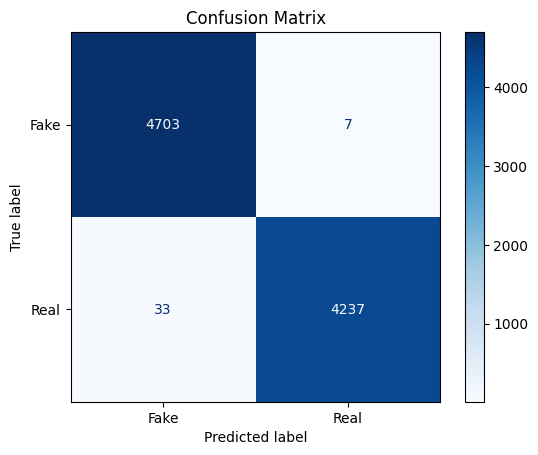

Accuracy:  1.00
Precision: 1.00
Recall:    0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4710
           1       1.00      0.99      1.00      4270

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [9]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Predict labels
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")  # For binary classification

# Flatten if needed
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Precision, recall, accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy:  {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


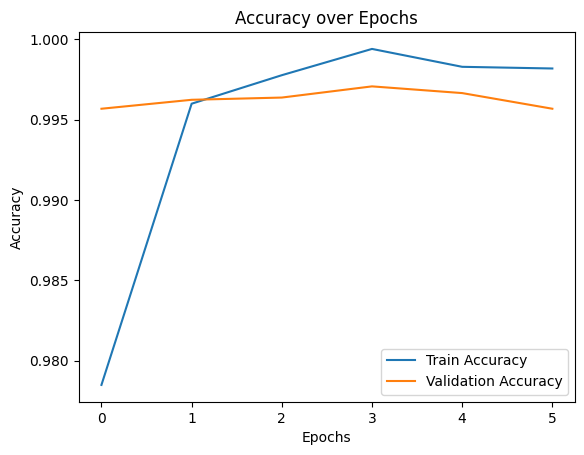

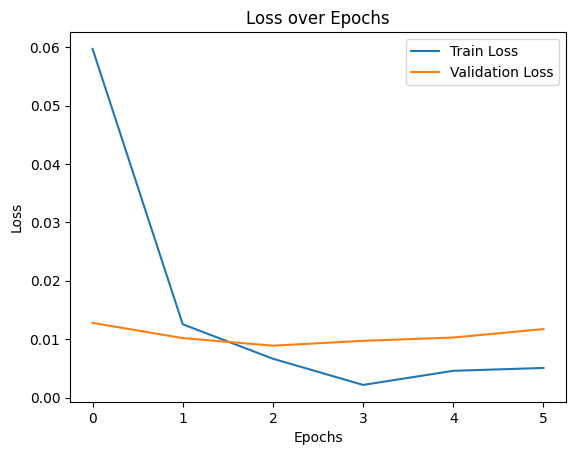

In [11]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
